In [1]:
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../raw_to_map'))
from sfkb_to_image_coordinates.sfkb_to_graph_dup import get_coverage_area
from tqdm import tqdm
from shapely.geometry import Polygon


In [2]:
coverage = get_coverage_area('../AgderOst/FG-14583_AgderØstGSD07')

In [20]:
def overlapping_polygons(sosi_path):

    sosi_path = os.path.join(sosi_path, 'DEKNINGSOVERSIKT')
    sosi_file = next((f for f in os.listdir(sosi_path) if f.endswith('Vertikalbilde.sos')), None)
    sosi_path = os.path.join(sosi_path, sosi_file)

    coverage_dict = {}
    current_id = None
    current_coords = []

    coords_start = False

    # Parse the SOSI file
    with open(sosi_path, 'r', encoding='latin-1') as infile:
        for line in infile:
            line = line.strip()
            if line.startswith('.FLATE'):
                if current_id and current_coords:
                    coverage_dict[current_id] = current_coords
                current_id = None
                current_coords = []
            elif line.startswith('...BILDEFILRGB'):
                try:
                    current_id = line.split('"')[1].split('.')[0]
                except:
                    current_id = line.split(' ')[1].split('.')[0]
            elif line.startswith('..NØ'):
                coords_start = True
            elif coords_start and line[0].isdigit():
                coords = [float(coord) for coord in line.split()][::-1]
                if len(coords) == 2:  # Ensure we only add pairs of coordinates
                    current_coords.append(coords)
            elif line.startswith('.KURVE'):
                coords_start = False

    # Add the last image if it exists
    if current_id and current_coords:
        coverage_dict[current_id] = current_coords

    # Process coverage areas
    for image_id, coords in tqdm(coverage_dict.items(), desc='Processing image coverage areas'):

        coverage_dict[image_id] = Polygon(np.array(coords))
    
    image_ids = list(coverage_dict.keys())
    overlapping_ids = {id:list() for id in image_ids}

    
    for i, id1 in enumerate(image_ids):
        area = coverage_dict[id1].area
        poly1 = coverage_dict[id1]
        for id2 in image_ids[i + 1:]:  # Avoid redundant checks
            poly2 = coverage_dict[id2]
            intersection = poly1.intersection(poly2)
            if not intersection.is_empty and intersection.area/area > 0.25:
                print (intersection.area/area)
                overlapping_ids[id1].append(id2)
                overlapping_ids[id2].append(id1)

    return coverage_dict, overlapping_ids

In [23]:
coverage, overlap = overlapping_polygons('../AgderOst/FG-14583_AgderØstGSD07')
with open('overlap.json', 'w') as json_file:
    json.dump(overlap, json_file, indent=4)

Processing image coverage areas: 100%|██████████| 34/34 [00:00<00:00, 17037.79it/s]

0.8035055594055079
0.6056950467319572
0.4095311382401053
0.25072344459601065
0.30512974833117823
0.803609111692025
0.6090361768512559
0.4137635894742687
0.25202033534187573
0.3049392005811953
0.8058653328661194
0.6110624264719398
0.4173336399251163
0.2562863645381466
0.30671077525518026
0.8053630007098423
0.6118578389070107
0.422381155819622
0.2583141970304764
0.3059437522504525
0.8069627306292098
0.61810111451353
0.4209541603972476
0.2636753226217764
0.3094462629707013
0.8106737080781902
0.6136773353570707
0.41714415103158786
0.2667956416719915
0.312328734735324
0.8030611674163218
0.6069540044298749
0.411040886394156
0.2669110268866726
0.31397655580240386
0.2537058064269075
0.8043393792959208
0.6090944596464698
0.41162094995593757
0.2637997150078823
0.31715559814042577
0.2525147429981716
0.8044317151774099
0.6064364362413477
0.40775793912086084
0.2600833066545091
0.31411703488140785
0.25268952252535487
0.8008743877004916
0.6019828743096212
0.4121800911907713
0.25953645631117983
0.3160

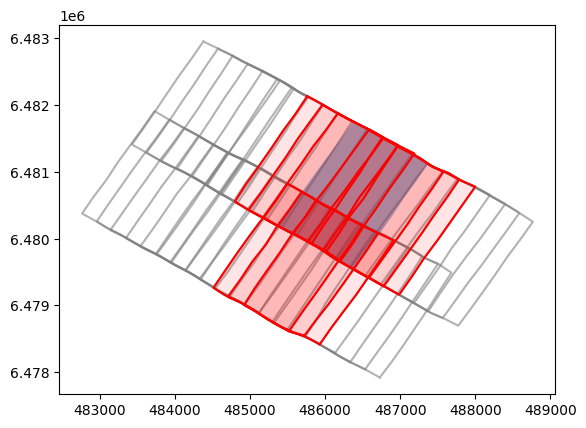

In [22]:
ids = list(coverage.keys())
for id in coverage.keys():
    #print(cov.exterior.xy)
    
    if id == ids[10]:    
        plt.fill(*coverage[id].exterior.xy, alpha=0.5)
        for adj_id in overlap[id]:
            plt.fill(*coverage[adj_id].exterior.xy, alpha=0.1, c='red')
            plt.plot(*coverage[adj_id].exterior.xy, c='red')
    else:
        plt.plot(*coverage[id].exterior.xy, c='grey', alpha=0.6, zorder=0)